In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import statsmodels.api as sm
import numpy as np
import mglearn 
from sklearn.cluster import KMeans

%matplotlib inline
import sklearn.model_selection as StandardScaler
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
plt.figure(figsize=(15, 10))

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

## 1. CARGA DE INFORMACION

In [42]:
import pyodbc 
conn = pyodbc.connect('Driver={SQL Server};'
                      'Server=SRVDWHBI;'
                      'Database=STAGING;'
                      'Trusted_Connection=yes;')

cursor = conn.cursor()
dataset = pd.read_sql_query("""SELECT * FROM STAGING..TEMP_ANALISIS_FRAUDE_EIS""",conn)

In [43]:
# Filtrado por EIS activos
dataset['id_distribuidor'] = dataset['id_distribuidor'].astype('object')
dataset = dataset[dataset['cod_estado']=='A']
dataset.describe()

,edad_anios,vigencia_meses,level_1,tiempo_ult_solicitud,tiempo_ult_consumo,cantidad_clientes,cantidad_clientes_estafador,solicitudes_ingresadas,solicitudes_califica,solicitudes_aprobadas,...,tasa_cuota_uno_impaga,tasa_negacion,tasa_negacion_inconsistencia,tasa_bloqueado_credito,tasa_bloqueado_cobranzas,tasa_consumo,tasa_vencimiento,comision_propia,comision_nivel,bonos
count,2627.000000,2627.000000,2627.000000,2627.000000,2627.000000,2627.000000,2627.0,2627.000000,2627.000000,2627.000000,...,2627.000000,2627.000000,2627.000000,2627.000000,2627.000000,2627.000000,2627.000000,2627.000000,2627.000000,2627.000000
mean,31.791397,11.425581,2.768938,2.570994,329.238675,52.076132,0.0,53.803198,34.969166,17.343738,...,0.057927,0.556164,0.139564,0.042396,0.026840,0.217398,0.155555,32.253305,24.350735,19.141594
std,10.482599,12.100465,7.133766,2.473124,468.153333,100.085053,0.0,103.552234,60.595001,31.963806,...,0.129014,0.267150,0.179352,0.129664,0.090788,0.219017,0.225795,60.048254,131.492627,64.642766
min,2.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.0,1.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,23.000000,5.000000,0.000000,0.000000,1.000000,4.000000,0.0,4.000000,3.000000,1.000000,...,0.000000,0.411765,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,29.000000,8.000000,0.000000,2.000000,3.000000,13.000000,0.0,14.000000,10.000000,5.000000,...,0.000000,0.533333,0.111111,0.000000,0.000000,0.200000,0.000000,7.231667,0.000000,0.000000
75%,38.000000,11.000000,2.000000,5.000000,999.000000,53.000000,0.0,54.000000,37.000000,18.000000,...,0.080000,0.692308,0.191489,0.000000,0.000000,0.333333,0.281114,31.479583,0.000000,8.333333
max,72.000000,76.000000,87.000000,10.000000,999.000000,1272.000000,0.0,1315.000000,505.000000,301.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,415.430000,2972.031667,721.250000


In [4]:
dataset.columns

Index(['fecha_proceso', 'id_distribuidor', 'des_sexo', 'num_identificacion',
       'des_estado_civil', 'des_almacen', 'cod_estado', 'fecha_ingreso',
       'fecha_baja', 'edad_anios', 'vigencia_meses', 'level_1',
       'fecha_ult_solicitud', 'fecha_ult_consumo', 'tiempo_ult_solicitud',
       'tiempo_ult_consumo', 'cantidad_clientes',
       'cantidad_clientes_estafador', 'solicitudes_ingresadas',
       'solicitudes_califica', 'solicitudes_aprobadas', 'solicitudes_negadas',
       'solicitudes_negadas_inconsistencia', 'cantidad_clientes_consumo',
       'cantidad_clientes_bloqueado', 'cantidad_clientes_bloqueado_cobranza',
       'cantidad_clientes_cuota_uno_impaga',
       'cantidad_clientes_gestion_negativa', 'plazo_promedio', 'monto_credito',
       'monto_corriente', 'monto_vencido', 'monto_vencer',
       'monto_transcurrido', 'tasa_califica', 'tasa_aprobacion',
       'tasa_estafador', 'tasa_gestion_negativa', 'tasa_cuota_uno_impaga',
       'tasa_negacion', 'tasa_negacion_inc

## 2. Analisis exploratorio

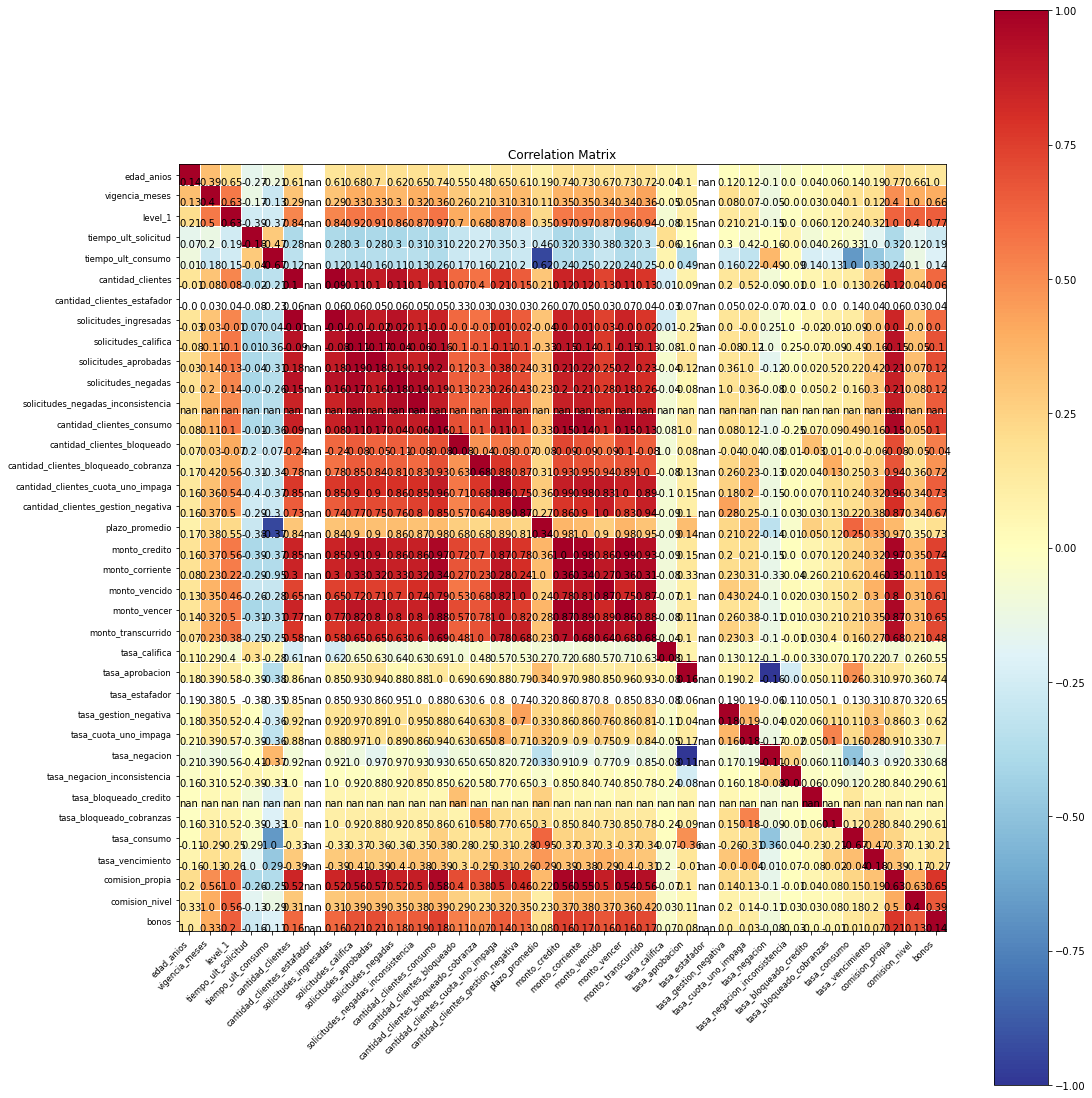

In [5]:
################################################
#MATRIZ CORRELACION DATASET ORIGINAL
################################################

plt.rcParams["figure.figsize"] = (16, 16)

corr = dataset.corr()
sm.graphics.plot_corr(corr, xnames=list(corr.columns))

for i in range(len(corr.columns)):
    for j in range(len(corr.columns)):
        plt.text(i, j, round(corr.iloc[i,j], 2))

plt.show()


In [44]:
#Eliminar campos con correlacion baja en nuevo dataframe df
df = dataset.select_dtypes(include=['float64', 'int64'])

df= df.drop([ 'edad_anios', 
        'tiempo_ult_solicitud',
       'tiempo_ult_consumo', 'cantidad_clientes',
       'cantidad_clientes_estafador', 'solicitudes_ingresadas',
       'solicitudes_califica', 'solicitudes_aprobadas', 'solicitudes_negadas',
       'solicitudes_negadas_inconsistencia', 'cantidad_clientes_consumo',
       'cantidad_clientes_bloqueado', 'cantidad_clientes_bloqueado_cobranza',
       'cantidad_clientes_cuota_uno_impaga',
       'cantidad_clientes_gestion_negativa', 'plazo_promedio', 'monto_credito',
       'monto_corriente', 'monto_vencido', 'monto_vencer', 'tasa_aprobacion','tasa_estafador',
       'monto_transcurrido', 'comision_propia'],axis=1)
df.shape

(2627, 13)

In [7]:
df.head()

,tasa_califica,tasa_gestion_negativa,tasa_cuota_uno_impaga,tasa_negacion,tasa_negacion_inconsistencia,tasa_bloqueado_credito,tasa_bloqueado_cobranzas,tasa_consumo,tasa_vencimiento
1,0.904000,0.066667,0.088889,0.362832,0.079646,0.044444,0.0,0.398230,0.406054
5,0.645161,0.000000,0.000000,0.350000,0.075000,0.000000,0.0,0.375000,0.000000
7,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.000000,0.000000
8,0.727273,0.000000,0.166667,0.250000,0.125000,0.166667,0.0,0.750000,0.393781
9,0.690476,0.111111,0.000000,0.551724,0.068966,0.111111,0.0,0.310345,0.184655


### 2.1 Reducción de dimensiones

In [45]:
################################################
#REDUCCIÓN DE DIMENSIONES PCA 
################################################

# You must normalize the data before applying the fit method
df_normalized=(df - df.mean()) / df.std()
pca = PCA(n_components=df.shape[1])
pca.fit(df_normalized)

# Reformat and view results
loadings = pd.DataFrame(pca.components_.T,
columns=['PC%s' % _ for _ in range(len(df_normalized.columns))],
index=df.columns)
print(loadings)

#plt.plot(pca.explained_variance_ratio_)
#plt.ylabel('Explained Variance')
#plt.xlabel('Components')
#plt.show()

                                   PC0       PC1       PC2       PC3  \
vigencia_meses                0.366586  0.181251  0.008232 -0.130273   
level_1                       0.430293  0.313138  0.009863 -0.007650   
tasa_califica                -0.037770 -0.016382 -0.153691 -0.773983   
tasa_gestion_negativa         0.238425 -0.259881  0.222381  0.081734   
tasa_cuota_uno_impaga         0.272062 -0.421226  0.303222 -0.060040   
tasa_negacion                -0.188019  0.241991  0.581001  0.112243   
tasa_negacion_inconsistencia -0.032434  0.102229  0.435793  0.004628   
tasa_bloqueado_credito        0.066287 -0.058006 -0.197806  0.561432   
tasa_bloqueado_cobranzas      0.198148 -0.375096  0.288405 -0.180854   
tasa_consumo                  0.261601 -0.282530 -0.415933  0.074535   
tasa_vencimiento              0.299874 -0.308953  0.108964  0.085966   
comision_nivel                0.378890  0.369053  0.010540 -0.010479   
bonos                         0.407671  0.315130  0.007103 -0.00

In [46]:
pca = PCA(n_components=2)
pca.fit(df_normalized)
#reduce a 2 dimenciones
transformada= pca.transform(df_normalized)
transformada.shape
dataset['id_distribuidor'].values

array([325, 961, 2282, ..., 15786, 15813, 15906], dtype=object)

Text(0, 0.5, 'PCA 2')

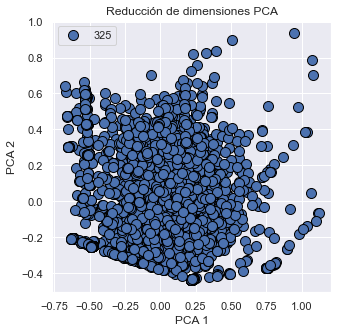

In [47]:
from sklearn.preprocessing import MinMaxScaler

escalar=MinMaxScaler()
escalar.fit(df_normalized)
escalada=escalar.transform(df_normalized)
pca.fit(escalada)
transformada=pca.transform(escalada)
mglearn.discrete_scatter(transformada[:,0], transformada[:,1])#, dataset['id_distribuidor'] )
plt.legend(dataset['id_distribuidor'].unique(), loc='best')
plt.title('Reducción de dimensiones PCA')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')

Text(0.5, 1.0, 'MATRIZ DE CORRELACION VARIABLES')

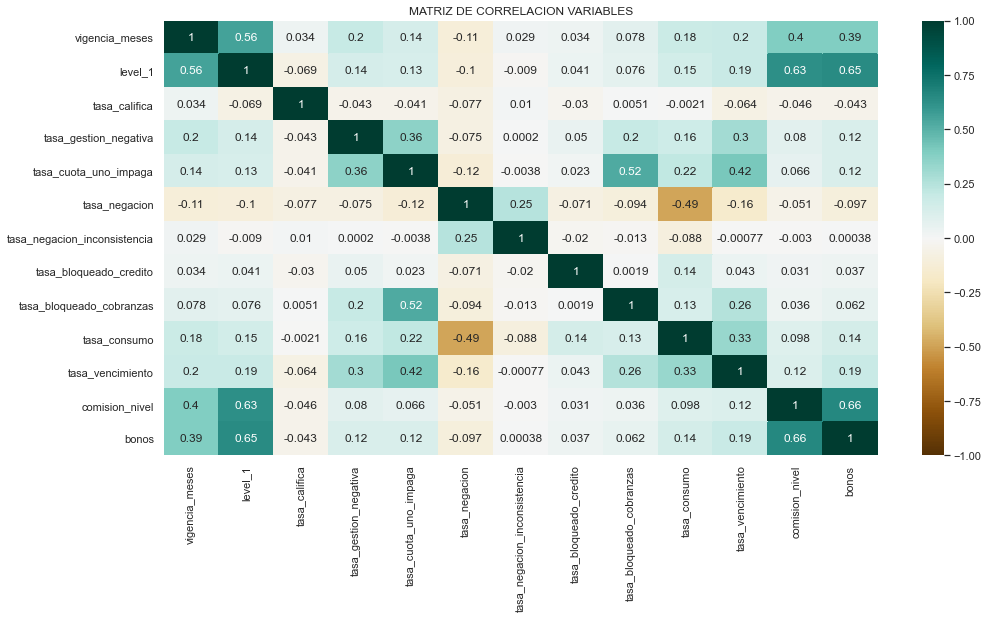

In [48]:
plt.figure(figsize=(16, 8))
#cmap = sns.cubehelix_palette(start = 1, rot = 3, gamma=0.8, as_cmap = True)   
heatmap = sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG')#, linewidths = 0.05, linecolor= 'red', ax = ax)   
heatmap.set_title('MATRIZ DE CORRELACION VARIABLES')
#heatmap.set_xlabel('region')


### 2.2 Districucion de los datos

In [49]:
#Dataset escalado para visualizacion

df_normalized[df_normalized.columns]=escalar.transform(df_normalized[df_normalized.columns])

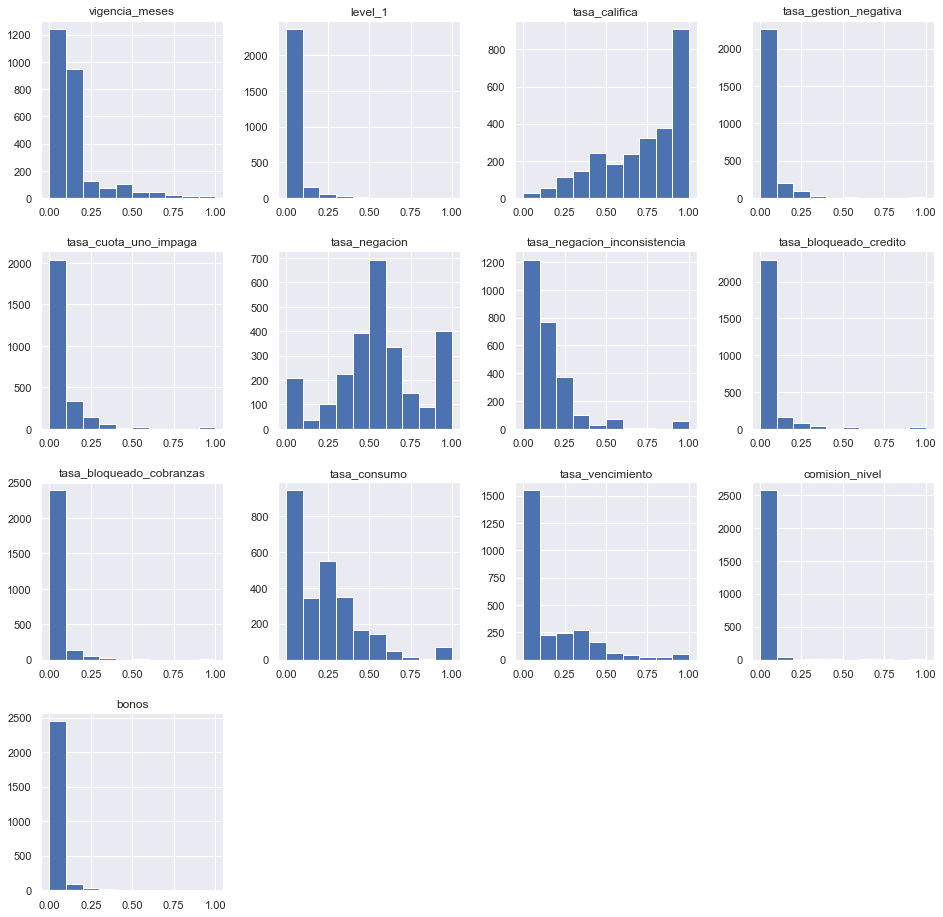

In [50]:
####################################################3
#DISTRIBUCION DE LOS DATOS
####################################################

plt.rcParams["figure.figsize"] = (16, 16)
df_normalized.hist()

#plt.title('DISTRIBUCIÓN DE LOS DATOS')
plt.show()

In [14]:
####################################
#CORRELACION ENTRE VARIABLES
##########################################
sns.set()
#cols = ["solicitudes_negadas_inconsistencia","monto_vencido","cantidad_clientes_bloqueado","tasa_negacion"]
cols = ["monto_credito","monto_vencido","monto_vencer","solicitudes_negadas_inconsistencia"]
sns.pairplot(df_normalized[cols], height = 2.5)
plt.show();

KeyError: "None of [Index(['monto_credito', 'monto_vencido', 'monto_vencer',\n       'solicitudes_negadas_inconsistencia'],\n      dtype='object')] are in the [columns]"

## 3. SEGMENTACIÓN KMEANS

In [51]:
# Convertir df a array
X = np.array(df_normalized.values)
X

array([[0.84210526, 0.16091954, 0.89333333, ..., 0.406054  , 0.4180426 ,
        0.81802426],
       [0.67105263, 0.11494253, 0.60573477, ..., 0.        , 0.03926663,
        0.02310803],
       [0.05263158, 0.        , 1.        , ..., 0.        , 0.00180909,
        0.        ],
       ...,
       [0.01315789, 0.        , 1.        , ..., 0.        , 0.        ,
        0.        ],
       [0.01315789, 0.        , 0.81481481, ..., 0.        , 0.        ,
        0.        ],
       [0.01315789, 0.        , 1.        , ..., 0.        , 0.        ,
        0.        ]])

#############KMENs FOCALIZADO
#X = np.array(dataset[["solicitudes_negadas_inconsistencia","monto_vencido","cantidad_clientes_bloqueado"]])
X = np.array(dataset[["monto_vencido","monto_vencer","solicitudes_negadas_inconsistencia"]])

### 3.1 Elbow method

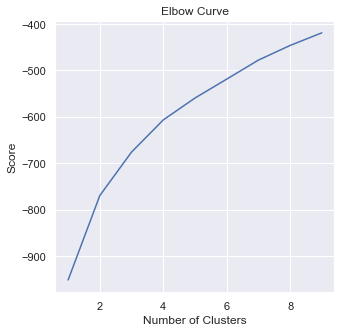

In [52]:
plt.rcParams["figure.figsize"] = (5, 5)

Nc = range(1, 10)
kmeans = [KMeans(n_clusters=i) for i in Nc]
kmeans
score = [kmeans[i].fit(X).score(X) for i in range(len(kmeans))]
score
plt.plot(Nc,score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

### 3.2 Clusterización

In [53]:
# standardizing the data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
data_scaled = scaler.fit_transform(df)


# statistics of scaled data
pd.DataFrame(data_scaled).describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12
count,2.627000e+03,2.627000e+03,2.627000e+03,2.627000e+03,2.627000e+03,2.627000e+03,2.627000e+03,2.627000e+03,2.627000e+03,2.627000e+03,2.627000e+03,2.627000e+03,2.627000e+03
mean,-2.929349e-15,3.996592e-15,-3.496759e-16,-2.244831e-15,2.356107e-15,-1.887421e-16,3.331937e-16,1.478748e-16,-2.555034e-15,9.046606e-16,-1.749563e-15,-2.590725e-15,-6.628543e-15
std,1.000190e+00,1.000190e+00,1.000190e+00,1.000190e+00,1.000190e+00,1.000190e+00,1.000190e+00,1.000190e+00,1.000190e+00,1.000190e+00,1.000190e+00,1.000190e+00,1.000190e+00
min,-9.444063e-01,-3.882192e-01,-2.856752e+00,-3.688983e-01,-4.490852e-01,-2.082238e+00,-7.783070e-01,-3.270323e-01,-2.956837e-01,-9.927985e-01,-6.890520e-01,-1.852223e-01,-2.961699e-01
25%,-5.311204e-01,-3.882192e-01,-7.112159e-01,-3.688983e-01,-4.490852e-01,-5.406206e-01,-7.783070e-01,-3.270323e-01,-2.956837e-01,-9.927985e-01,-6.890520e-01,-1.852223e-01,-2.961699e-01
50%,-2.831488e-01,-3.882192e-01,2.403192e-01,-3.688983e-01,-4.490852e-01,-8.547646e-02,-1.586741e-01,-3.270323e-01,-2.956837e-01,-7.945323e-02,-6.890520e-01,-1.852223e-01,-2.961699e-01
75%,-3.517729e-02,-1.078090e-01,1.055338e+00,-3.688983e-01,1.711190e-01,5.097121e-01,2.895710e-01,-3.270323e-01,-2.956837e-01,5.294436e-01,5.561774e-01,-1.852223e-01,-1.672317e-01
max,5.337540e+00,1.180963e+01,1.055338e+00,9.336751e+00,7.303467e+00,1.661690e+00,4.798389e+00,7.386677e+00,1.072105e+01,3.573928e+00,3.740580e+00,2.242135e+01,1.086343e+01


In [54]:
# defining the kmeans function with initialization as k-means++
kmeans = KMeans(n_clusters=4, init='k-means++')

# fitting the k means algorithm on scaled data
kmeans.fit(data_scaled)

kmeans.inertia_
# inertia on the fitted data
pred = kmeans.predict(data_scaled)

### 3.3 Vista 3D y 2D de variales

In [24]:

# Getting the cluster centers
C = kmeans.cluster_centers_
colores=['red','green','blue'] #,'yellow','cyan'
asignar=[]
for row in pred:
    asignar.append(colores[row])
 
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=asignar,s=30)
#ax.scatter(C[:, 0], C[:, 1], C[:, 2], marker='*', c=colores, s=500)

IndexError: list index out of range

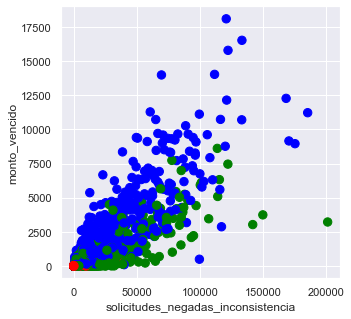

In [20]:
f1 = dataset["monto_vencer"].values
f2 = dataset['monto_vencido'].values
 
plt.scatter(f1, f2, c=asignar, s=70)
#plt.scatter(C[:, 0], C[:, 1], marker='*', c=colores, s=1000)
plt.xlabel('solicitudes_negadas_inconsistencia')
plt.ylabel('monto_vencido')
plt.show()

### 3.2 Asignar segmento en DataFrame

In [55]:
df_normalized['target'] = pred
dataset['target'] = pred
#dataset['target'] = dataset['target'].astype(object)


In [56]:
df_normalized['target'].value_counts()

0    969
3    853
2    732
1     73
Name: target, dtype: int64

## 4. PERFIL DE SEGMENTOS

In [57]:

#Proporción de segmentos
dataGrupo= df_normalized.groupby('target').agg({ 
    'vigencia_meses': [np.mean],
'level_1': [np.mean],
'tasa_gestion_negativa': [np.mean],
'tasa_cuota_uno_impaga': [np.mean],
'tasa_negacion': [np.mean],
'tasa_negacion_inconsistencia': [np.mean],
'tasa_bloqueado_cobranzas': [np.mean],
'tasa_bloqueado_credito': [np.mean],
'tasa_consumo': [np.mean],
'tasa_vencimiento': [np.mean],
    'comision_nivel': [np.mean],
'bonos': [np.mean]
})

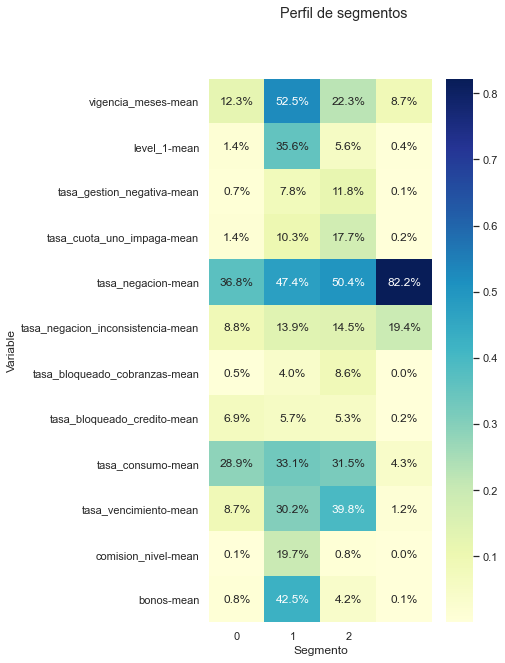

In [58]:
fig, ax = plt.subplots(figsize=(5,10))
_=sns.heatmap(np.transpose(dataGrupo) ,annot=True,fmt=".1%",cmap="YlGnBu",
xticklabels = ["0","1","2"])#
_=plt.yticks(rotation=0)
_=plt.xlabel("Segmento")
_=plt.ylabel("Variable")
_=plt.suptitle("Perfil de segmentos")
_=plt.savefig("Correlaciones Pearson.jpg")

In [59]:
print("Grupo 1: ",len(dataset[dataset['target']==0]))
print('Grupo 2 : ',len(dataset[dataset['target']==1]))
print("Grupo 3: ",len(dataset[dataset['target']==2]))
print("Grupo 4: ",len(dataset[dataset['target']==3]))

Grupo 1:  969
Grupo 2 :  73
Grupo 3:  732
Grupo 4:  853


In [ ]:
#corte el run
vista.head()

### 4.1 Asignación semaforo a cada segmento

In [60]:
# Segmento con mayor proporcion se asigna semaforo rojo luego amarillo y verde
dataset['target'] = dataset['target'].astype(object)

def target(dataset):
    if dataset['target'] == 0:
        return 'Verde'
    elif dataset['target'] == 3:
        return 'Amarillo'
    elif dataset['target'] == 2:
        return 'Naranja'
    else:
        return 'Rojo'

In [61]:
analizar = dataset
analizar['target'] = analizar.apply(target, axis=1)


Amarillo    853
Naranja     732
Rojo         73
Verde       969
Name: target, dtype: int64


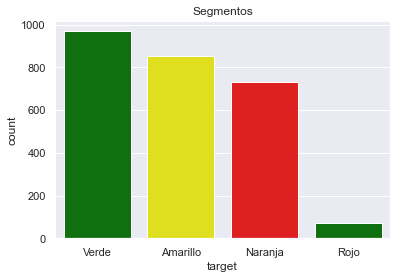

In [62]:
# Segmentos
fig, ax = plt.subplots(figsize=(6,4))
plt.title('Segmentos', fontsize = 'medium')
sns.countplot(data = analizar, x='target',palette= ['green','yellow','red'],order = analizar['target'].value_counts().index)
print(analizar.target.value_counts().sort_index())

### 4.2 Promedio de variables por perfiles


In [36]:
dataset[['monto_vencer', 'monto_vencido','target']].groupby(['target']).agg(["mean","median","count"])
#.sort_values(by = 'target', ascending = True)

monto_vencer                  monto_vencido               
                  mean     median count          mean   median count
target                                                              
Amarillo    926.767171      0.000   898     13.666058     0.00   898
Naranja   25136.590894  12550.740   649   2201.614761  1067.80   649
Rojo       2182.513269   2288.445    52     26.763846     0.00    52
Verde     13039.634737   4676.175  1028    512.528103    33.49  1028

In [37]:
dataset[[ 'cantidad_clientes_bloqueado', 'cantidad_clientes_bloqueado_cobranza',
       'cantidad_clientes_cuota_uno_impaga','cantidad_clientes_gestion_negativa','target']].groupby(['target']).agg(["mean","median","count"])
#.sort_values(by = 'target', ascending = True)

cantidad_clientes_bloqueado               \
                                mean median count   
target                                              
Amarillo                    0.021158      0   898   
Naranja                     1.064715      0   649   
Rojo                        1.057692      1    52   
Verde                       0.589494      0  1028   

         cantidad_clientes_bloqueado_cobranza               \
                                         mean median count   
target                                                       
Amarillo                             0.003341      0   898   
Naranja                              1.331279      1   649   
Rojo                                 0.000000      0    52   
Verde                                0.234436      0  1028   

         cantidad_clientes_cuota_uno_impaga               \
                                       mean median count   
target                                                     
Amarillo                           0.012249      0   898   
Naranja                            2.981510      2   649   
Rojo                               0.057692      0    52   
Verde                              0.630350      0  1028   

         cantidad_clientes_gestion_negativa               
                                       mean median count  
target                                                    
Amarillo                           0.005568      0   898  
Naranja                            2.206471      1   649  
Rojo                               0.096154      0    52  
Verde                              0.401751      0  1028

In [38]:
dataset[['solicitudes_ingresadas',
       'solicitudes_califica', 'solicitudes_aprobadas', 'solicitudes_negadas',
       'solicitudes_negadas_inconsistencia','target']].groupby(['target']).agg(["mean","median","count"])
#.sort_values(by = 'target', ascending = True)

solicitudes_ingresadas              solicitudes_califica         \
                           mean median count                 mean median   
target                                                                     
Amarillo              12.122494      5   898             7.261693      3   
Naranja              116.442219     56   649            69.963020     37   
Rojo                  13.480769      9    52             8.423077      8   
Verde                 52.707198     16  1028            38.423152     13   

               solicitudes_aprobadas              solicitudes_negadas         \
         count                  mean median count                mean median   
target                                                                         
Amarillo   898              2.103563      1   898            4.851893    2.0   
Naranja    649             33.907550     18   649           33.627119   19.0   
Rojo        52              3.653846      3    52            4.480769    3.5   
Verde     1028             20.892023      7  1028           16.038911    5.0   

               solicitudes_negadas_inconsistencia               
         count                               mean median count  
target                                                          
Amarillo   898                           1.261693      1   898  
Naranja    649                          10.409861      6   649  
Rojo        52                           1.076923      1    52  
Verde     1028                           4.666342      1  1028

In [63]:
dataset[['tasa_califica', 'tasa_aprobacion','tasa_negacion','target']].groupby(['target']).agg(["mean","median","count"])
#.sort_values(by = 'target', ascending = True)

tasa_califica                 tasa_aprobacion                  \
                  mean    median count            mean    median count   
target                                                                   
Amarillo      0.734362  0.800000   853        0.177759  0.166667   853   
Naranja       0.723567  0.770960   732        0.496304  0.483871   732   
Rojo          0.722726  0.765172    73        0.525573  0.521739    73   
Verde         0.805344  0.875000   969        0.632267  0.576923   969   

         tasa_negacion                  
                  mean    median count  
target                                  
Amarillo      0.822241  0.833333   853  
Naranja       0.503696  0.516129   732  
Rojo          0.474427  0.478261    73  
Verde         0.367733  0.423077   969

In [64]:
dataset[['tasa_bloqueado_credito', 'tasa_bloqueado_cobranzas','tasa_vencimiento', 'tasa_negacion_inconsistencia','target']].groupby(['target']).agg(["mean","median","count"])
#.sort_values(by = 'target', ascending = True)

tasa_bloqueado_credito                 tasa_bloqueado_cobranzas  \
                           mean    median count                     mean   
target                                                                     
Amarillo               0.001942  0.000000   853                 0.000078   
Naranja                0.053374  0.000000   732                 0.086276   
Rojo                   0.056515  0.043478    73                 0.039689   
Verde                  0.068651  0.000000   969                 0.004530   

                         tasa_vencimiento                  \
            median count             mean    median count   
target                                                      
Amarillo  0.000000   853         0.012419  0.000000   853   
Naranja   0.032258   732         0.397896  0.357337   732   
Rojo      0.025641    73         0.301974  0.330767    73   
Verde     0.000000   969         0.087458  0.000000   969   

         tasa_negacion_inconsistencia                  
                                 mean    median count  
target                                                 
Amarillo                     0.194390  0.108108   853  
Naranja                      0.144541  0.138889   732  
Rojo                         0.138601  0.137931    73  
Verde                        0.087615  0.064516   969

In [65]:
dataset[[ 'tasa_gestion_negativa', 'tasa_cuota_uno_impaga','target']].groupby(['target']).agg(["mean","median","count"])
#.sort_values(by = 'target', ascending = True)

tasa_gestion_negativa                 tasa_cuota_uno_impaga  \
                          mean    median count                  mean   
target                                                                 
Amarillo              0.000796  0.000000   853              0.001679   
Naranja               0.118144  0.072078   732              0.176948   
Rojo                  0.078297  0.071429    73              0.102831   
Verde                 0.007196  0.000000   969              0.014150   

                          
            median count  
target                    
Amarillo  0.000000   853  
Naranja   0.137931   732  
Rojo      0.107843    73  
Verde     0.000000   969

### 4.3 Visualizacion por perfiles

In [ ]:
plt.rcParams['figure.figsize'] = (16, 9)
# plt.style.use('ggplot')
sns.pairplot(dataset.dropna(), hue='target',
             height=4,
             vars=['monto_credito', 'monto_vencido', 'monto_vencer'],
             kind='reg',
             palette=['yellow','green','red']
             #palette='gnuplot_r'
            )

In [ ]:
plt.rcParams['figure.figsize'] = (16, 9)
plt.style.use('ggplot')
sns.pairplot(dataset.dropna(), hue='target',
             height=4,
             vars=['cantidad_clientes_consumo',
       'cantidad_clientes_bloqueado', 'cantidad_clientes_bloqueado_cobranza',
       'cantidad_clientes_cuota_uno_impaga',
       'cantidad_clientes_gestion_negativa'],
             kind='reg',
             palette=['yellow','green','red'])

In [ ]:
plt.rcParams['figure.figsize'] = (16, 9)
plt.style.use('ggplot')
sns.pairplot(dataset.dropna(), hue='target',
             height=4,
             vars=['comision_propia', 'comision_nivel', 'bonos'],
             kind='reg',
             palette=['yellow','green','red'])

In [ ]:
plt.rcParams['figure.figsize'] = (16, 9)
plt.style.use('ggplot')
sns.pairplot(dataset.dropna(), hue='target',
             height=4,
             vars=['solicitudes_ingresadas','solicitudes_califica', 'solicitudes_aprobadas', 'solicitudes_negadas',
       'solicitudes_negadas_inconsistencia'],
             kind='reg',
             palette=['yellow','green','red'])

In [ ]:
plt.rcParams['figure.figsize'] = (16, 9)
plt.style.use('ggplot')
sns.pairplot(dataset.dropna(), hue='target',
             height=4,
             vars=[ 'cantidad_clientes_bloqueado', 'cantidad_clientes_bloqueado_cobranza',
       'cantidad_clientes_cuota_uno_impaga','cantidad_clientes_gestion_negativa','comision_propia'],
             kind='reg',
             palette=['yellow','green','red'])

In [ ]:
# seleccionamos las variables para el score
df_score =dataset[['id_distribuidor','tasa_vencimiento','tasa_estafador', 'tasa_gestion_negativa', 'tasa_cuota_uno_impaga',
'tasa_negacion', 'tasa_negacion_inconsistencia',
'tasa_bloqueado_credito', 'tasa_bloqueado_cobranzas']]

In [ ]:
quantiles = df_score.quantile(q=[0.25,0.5,0.75])
quantiles

In [ ]:
# Converting quantiles to a dictionary, easier to use.
def tasa_valor(x,p,d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]:
        return 3
    else:
        return 4


In [ ]:
#categoriza cada variable
df_score['tv'] = df_score['tasa_vencimiento'].apply(tasa_valor, args=('tasa_vencimiento',quantiles,))
df_score['te'] = df_score['tasa_estafador'].apply(tasa_valor, args=('tasa_estafador',quantiles,))
df_score['tgn'] = df_score['tasa_gestion_negativa'].apply(tasa_valor, args=('tasa_gestion_negativa',quantiles,))
df_score['tci'] = df_score['tasa_cuota_uno_impaga'].apply(tasa_valor, args=('tasa_cuota_uno_impaga',quantiles,))
df_score['tn'] = df_score['tasa_negacion'].apply(tasa_valor, args=('tasa_negacion',quantiles,))
df_score['tni'] = df_score['tasa_negacion_inconsistencia'].apply(tasa_valor, args=('tasa_negacion_inconsistencia',quantiles,))
df_score['tbc'] = df_score['tasa_bloqueado_credito'].apply(tasa_valor, args=('tasa_bloqueado_credito',quantiles,))
df_score['tbc2'] = df_score['tasa_bloqueado_cobranzas'].apply(tasa_valor, args=('tasa_bloqueado_cobranzas',quantiles,))

In [ ]:
#agrupa score final
df_score['Score'] = df_score.tv.map(str) \
+ df_score.te.map(str) \
+ df_score.tgn.map(str) \
+ df_score.tci.map(str) \
+ df_score.tn.map(str) \
+ df_score.tni.map(str) \
+ df_score.tbc.map(str) \
+ df_score.tbc2.map(str)

In [ ]:
#Suma score final
df_score['SScore'] = df_score.tv * 30 \
+ df_score.te *5 \
+ df_score.tgn *5 \
+ df_score.tci * 20 \
+ df_score.tn *5\
+ df_score.tni *5\
+ df_score.tbc * 15 \
+ df_score.tbc2 * 15

In [ ]:
df_score.describe().T




In [ ]:

df_score.sort_values('SScore',ascending = False).head(10)



In [ ]:
dataset = dataset.merge(df_score[[ 'SScore','id_distribuidor']],left_on="id_distribuidor", right_on="id_distribuidor")



In [ ]:
dataset.sort_values('SScore',ascending = False).head(10)

In [ ]:
dataset.describe().T

## 5. GUARDAR CLUSTER

In [ ]:
analizar.to_csv('eis_fraude.csv')

analizar.to_csv('eis_faude.csv')